<img src="./img/logo-ilsp.png" alt="Drawing" style="width: 90px; float: left"/>
<img src="./img/logo-proserve.png" alt="Drawing" style="width: 150px; float: right"/>

<br>
<br>
<center>
    <font size=6><b> AI/ML Experiment - Vehicle Theft Detection</b></font>
    

# Second notebook - Modelling

In [1]:
%%capture
!pip install --upgrade pip

In [2]:
%%capture
!pip install geopandas==0.5.1 descartes geohash2 xgboost datawig geohash_hilbert shapely googlemaps tqdm pydotplus treeinterpreter imblearn pyarrow shap dill bayesian-optimization

In [3]:
%%capture
!conda install seaborn==0.9.0 -y

In [4]:
# important libraries used throughout notebook
import numpy as np
import pandas as pd
import geopandas
import datetime
import seaborn as sns
import geohash2
import geohash_hilbert as ghh
from sklearn import preprocessing
import matplotlib.pyplot as plt
import geohash_hilbert as ghh
from shapely.geometry import Polygon
import googlemaps
from tqdm import tqdm
import shap

In [5]:
# This command is called a Magic, and modifies the way that Jupyter displays images, graphs, etc...
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

# This is setting pandas settings so that we can see more/ess rows and columns of our dataframes.
# We end up with a lot of columns later on, so we set the number of columns high.
pd.options.display.max_rows = 50
pd.options.display.max_columns = 500

# np.set_printoptions(precision=2)

# Checkpoint our datasets
At this point we create binary files of our datasets. This is the quickest way to do this.

In [17]:

# X_train.to_feather('X_train')
# X_test.to_feather('X_test')
# pd.DataFrame(y_train, columns=['is_theft']).to_feather('y_train')
# pd.DataFrame(y_test, columns=['is_theft']).to_feather('y_test')


In [6]:
X_train = pd.read_feather('X_train')
X_test = pd.read_feather('X_test')
y_train = pd.read_feather('y_train').values.ravel()
y_test = pd.read_feather('y_test').values.ravel()

In [9]:
X_train.head()

has_custody  customer_id_4  customer_id_5  customer_id_16  customer_id_19  \
0            1              0              0               0               0   
1            1              0              0               0               0   
2            1              0              0               0               0   
3            0              0              0               0               0   
4            0              0              0               0               0   

   customer_id_21  customer_id_22  customer_id_25  customer_id_29  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   customer_id_31  customer_id_35  customer_id_36  customer_id_37  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   customer_id_39  customer_id_40  customer_id_41  customer_id_45  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   customer_id_46  customer_id_47  customer_id_50  customer_id_51  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   customer_id_53  customer_id_57  customer_id_68  customer_id_69  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   customer_id_74  customer_id_79  customer_id_81  customer_id_82  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               1   

   customer_id_83  customer_id_93  customer_id_102  customer_id_108  \
0               0               0                0                0   
1               0               0                0                0   
2               0               0                0                0   
3               0               0                0                0   
4               0               0                0                0   

   customer_id_118  customer_id_141  customer_id_142  customer_id_147  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   customer_id_152  customer_id_156  customer_id_158  customer_id_161  \
0                0                0                0                0   
1                0  

Partition Around Medoids

# PCA
We can try visualizing our data in 2-dimensions. This can show us perhaps how much variation there is in the data itself, if there are noticeable clusters, and whether theft events often seem to occur in clustered groups

In [235]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

# Note, this is not really effective for categorical/binary variables. Won't really work.

from sklearn.decomposition import PCA


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [27]:
finalDf = pd.concat([principalDf, pd.DataFrame(y_train, columns=['is_theft'])], axis = 1)

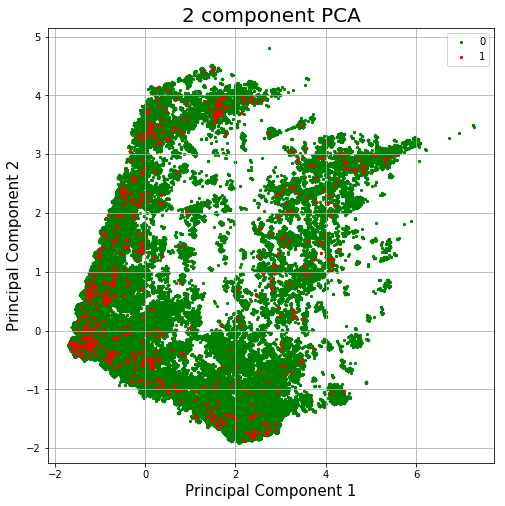

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_theft'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 5)
ax.legend(targets)
ax.grid()

# K means Clustering

In [6]:
from sklearn.cluster import KMeans

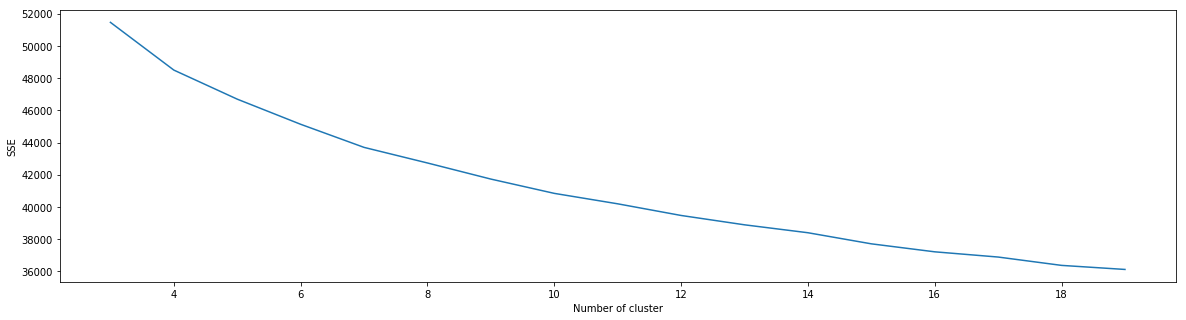

In [9]:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
    
sse = {}
for k in range(3, 20):
    kmeans = KMeans(n_clusters=k, max_iter=50, verbose=0, n_jobs=-1).fit(X_train_under)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [26]:
# Looks like 10 is a reasonable number of clusters, as it seems to decrease smoothly afterwards.
kmeans = KMeans(n_clusters=10, max_iter=50, verbose=0, n_jobs=-1).fit(X_train_under)
print('overall number of trips in each cluster is:')
print(np.unique(kmeans.labels_, return_counts=True))
print()
print('number of thefts in each cluster is:')
print(np.unique(kmeans.labels_[y_train_under == 1], return_counts=True))
print()
print('proportion of thefts in each cluster:')
print(np.unique(kmeans.labels_[y_train_under == 1], return_counts=True)[1]/np.unique(kmeans.labels_[y_train_under == 0],
                                                                                     return_counts=True)[1])

# Clusters 3 and 8 have  much higher proportion of thefts that the others. Perhaps we can add this

overall number of trips in each cluster is:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([673, 978, 256, 319, 512, 380, 391, 304, 232, 203]))

number of thefts in each cluster is:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 60,  81,  45, 127, 147,  76,  24,  28,  91,  29]))

proportion of thefts in each cluster:
[0.09 0.08 0.18 0.4  0.29 0.2  0.06 0.09 0.39 0.14]


In [36]:
# Let's see if this is represented in our testing set too.
kmeans.predict(X_test)

for i in (np.unique(kmeans.predict(X_test)[y_test == 1], return_counts=True)[1]/np.unique(kmeans.predict(X_test)[y_test == 0],
                                                                                     return_counts=True)[1]):
    print(i)
    
# It looks like maybe yes, but hard to tell for sure. The same cluster is the most common ratio
# of thefts compared to the others again

0.0004581514793470136
0.0005550245135826832
0.0010945709281961471
0.0030620308178585538
0.001523954662348795
0.0013412017167381974
0.0005825384111264836
0.0005885815185403178
0.0017267429311461256
0.0011460720983538237


In [41]:
# We can try adding this as a column to our datasets
X_train_km = X_train.copy()
X_train_km = pd.concat([X_train_km, pd.get_dummies(kmeans.predict(X_train_km), prefix='cluster_')], axis=1)

X_test_km = X_test.copy()
X_test_km = pd.concat([X_test_km, pd.get_dummies(kmeans.predict(X_test_km), prefix='cluster_')], axis=1)

# Modelling Utils
Here we start the modelling process
first import some importance libraries

In [7]:
# For Visualizing trees
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, \
precision_score, confusion_matrix, precision_recall_curve, make_scorer

In [8]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823


def print_confusion_matrix(confusion_matrix, class_names = ['no_robo', 'robo'], figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [9]:
# https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5

def show_metrics(y_true, y_score):
    y_true = y_true.astype(float)
    y_score = y_score.astype(float)
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    auc = (tpr+tnr) / 2
    # MCC
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    print("ACCURACY : {0:.2f}% (What proportion of classes are being classified as theft or not theft correctly?)".format(accuracy*100))
    print("PRECISION: {0:.2f}% (If predicted as theft, how likely is it to be theft?)".format(precision*100))
    print("RECALL   : {0:.2f}% (If it was theft, how likely is it I predicted it?)".format(tpr*100))
    print()
    print("F1: {0:.4f}".format(f1))
    print()
    print("baseline proportion of thefts is ~ 0.09%")
    print("with this model, a journey predicted as theft is {0:.2f}x more likely to be stolen".format(precision/0.0009))
#     print("ROC-AUC: {0:.4f}".format(auc))

In [10]:
def print_roc(y_true, y_predicted):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(false_positive_rate, true_positive_rate, marker='.')
    # show the plot
    plt.show()


def print_precision_recall_curve(y_true, y_predicted):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    # show the plot
    plt.show()

In [11]:
def print_decision_tree(decision_tree):
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph.create_png()

# Imbalanced learn
We will interchangeably use different resampled datasets. This may help deal with the large class imbalance.

In [12]:
# Oversampling
from imblearn.over_sampling import SMOTE
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=0, replacement=False)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print('number of thefts vs non-thefts in oversampled dataset =', np.unique(y_train_smote, return_counts=True))
print('number of thefts vs non-thefts in undersampled dataset =', np.unique(y_train_under, return_counts=True))

number of thefts vs non-thefts in oversampled dataset = (array([0, 1]), array([775006, 775006]))
number of thefts vs non-thefts in undersampled dataset = (array([0, 1]), array([3540,  708]))


# Naive model
If we just predict the most common class (no-robo), or predict randomly - proportionally, how effective is a model? 

This is our baseline - we want this model to make sure that we can improve on this to see if it has actually learned something.

In [197]:
# Naive is just always predicting zero
y_naive = np.zeros(len(y_test))

# random model randomly predicts thefts, based on proportion
y_random = np.zeros(len(y_test))
proportion_of_thefts_in_test_set = np.unique(y_test, return_counts=True)[1][1] / (np.unique(y_test, return_counts=True)[1][0] +
                                                                                  np.unique(y_test, return_counts=True)[1][1])
indices = np.random.choice(np.arange(y_random.size), replace=False,
                           size=int(y_random.size * proportion_of_thefts_in_test_set))
y_random[indices] = 1

# our next baseline model predicts journeys that pass through known dangerous geohash as thefts
y_random_geohash = y_random = pd.Series(np.zeros(len(y_test)))
y_random_geohash[X_test['geohash_'+str(1012232200)][X_test['geohash_'+str(1012232200)] == 1].index] = 1

ACCURACY : 99.91% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: nan% (If predicted as theft, how likely is it to be theft?)
RECALL   : 0.00% (If it was theft, how likely is it I predicted it?)

F1: 0.0000
ROC-AUC: 0.5000


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


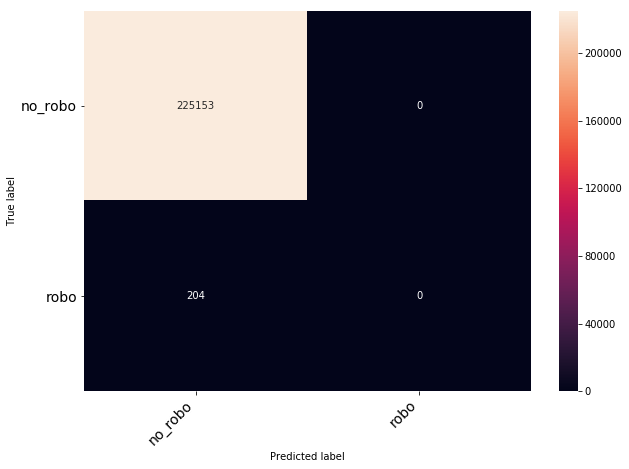

In [62]:
# How does our naive model do? We see it has almost perfect accuracy but undefined precision and 0 recall.
print_confusion_matrix(confusion_matrix(y_test, y_naive), figsize = (10,7), fontsize=14);
show_metrics(y_test, y_naive)

0.5


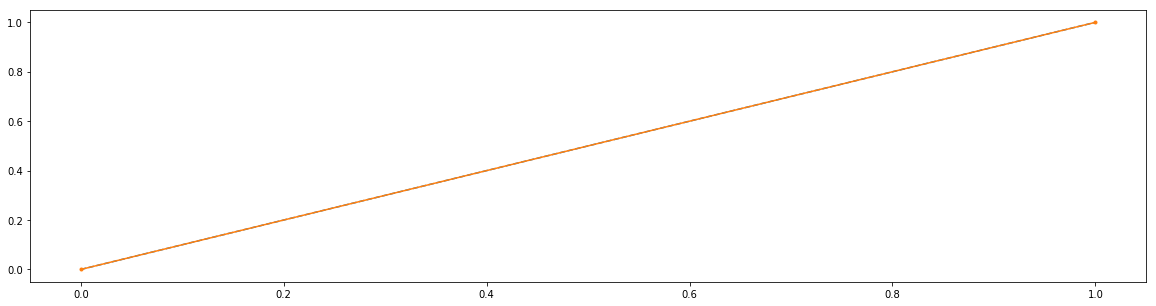

In [63]:
print_roc(y_test, y_naive)

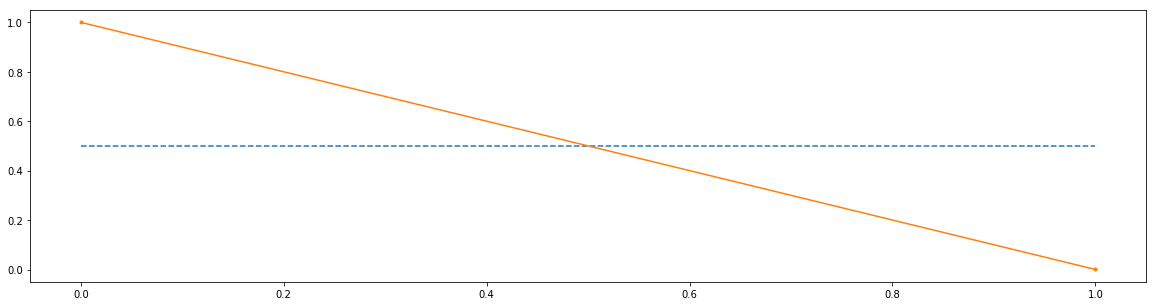

In [64]:
print_precision_recall_curve(y_test, y_naive)

ACCURACY : 81.29% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.11% (If predicted as theft, how likely is it to be theft?)
RECALL   : 23.04% (If it was theft, how likely is it I predicted it?)

F1: 0.0022
ROC-AUC: 0.5219


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


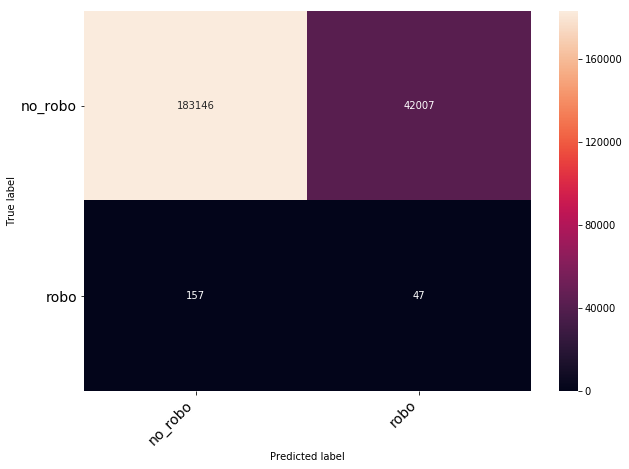

In [65]:
# If we do the same for our random test set, we can see that the model has again, very high accuracy (not quite as high),
# but zero low precision and recall. We can see that neither of these models as useful, as expected, despite having
# very high accuracy. We will need to focus on improving both precision and recall, or a balance between them (f1 score)
print_confusion_matrix(confusion_matrix(y_test, y_random), figsize = (10,7), fontsize=14);
show_metrics(y_test, y_random)

0.5219106236517338


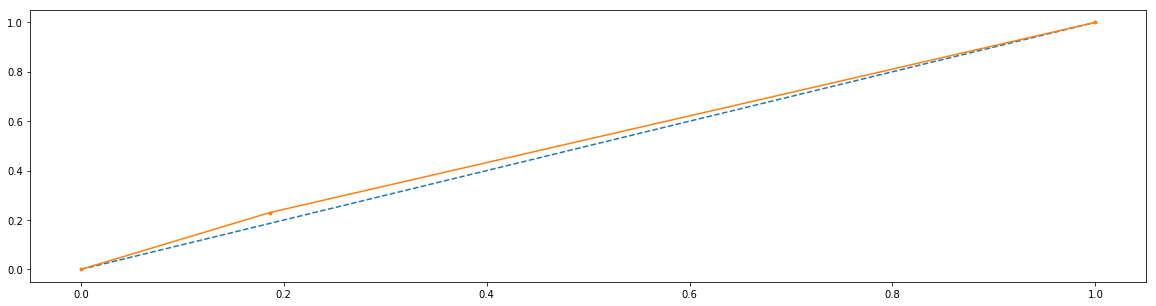

In [66]:
print_roc(y_test, y_random)

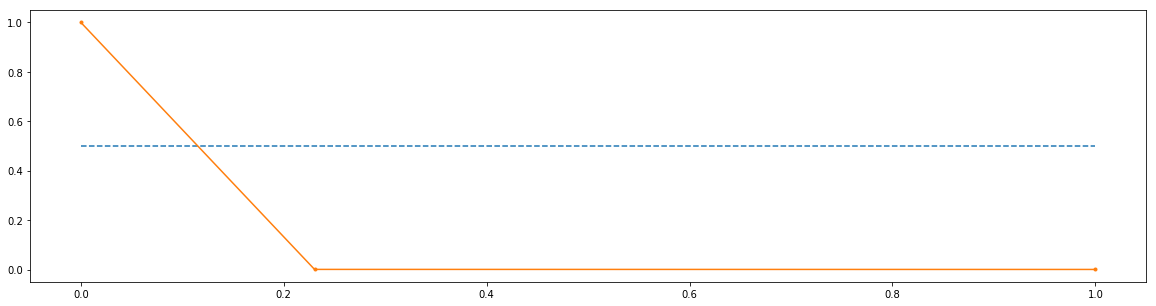

In [67]:
print_precision_recall_curve(y_test, y_random)

ACCURACY : 81.29% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.11% (If predicted as theft, how likely is it to be theft?)
RECALL   : 23.04% (If it was theft, how likely is it I predicted it?)

F1: 0.0022
ROC-AUC: 0.5219


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


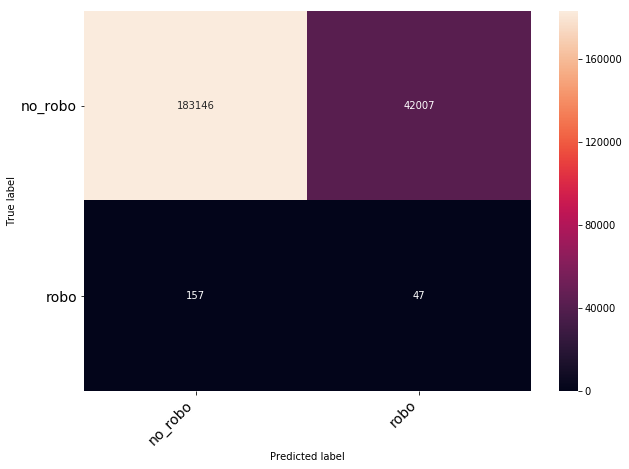

In [68]:
# If we do the same for our random test set, we can see that the model has again, very high accuracy (not quite as high),
# but zero low precision and recall. We can see that neither of these models as useful, as expected, despite having
# very high accuracy. We will need to focus on improving both precision and recall, or a balance between them (f1 score)
print_confusion_matrix(confusion_matrix(y_test, y_random_geohash), figsize = (10,7), fontsize=14);
show_metrics(y_test, y_random_geohash)

0.5219106236517338


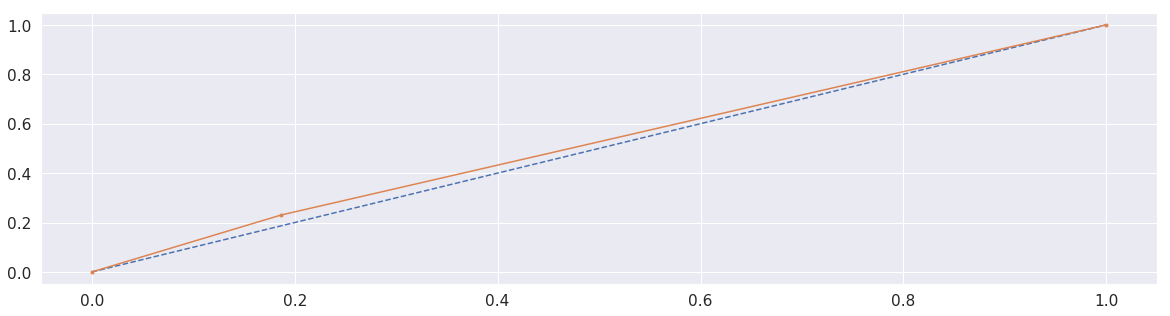

In [209]:
# We can see a marginal improvement over the previous baseline models, based on a fixed rule (if it passes through this route - dangerous).
print_roc(y_test, y_random)

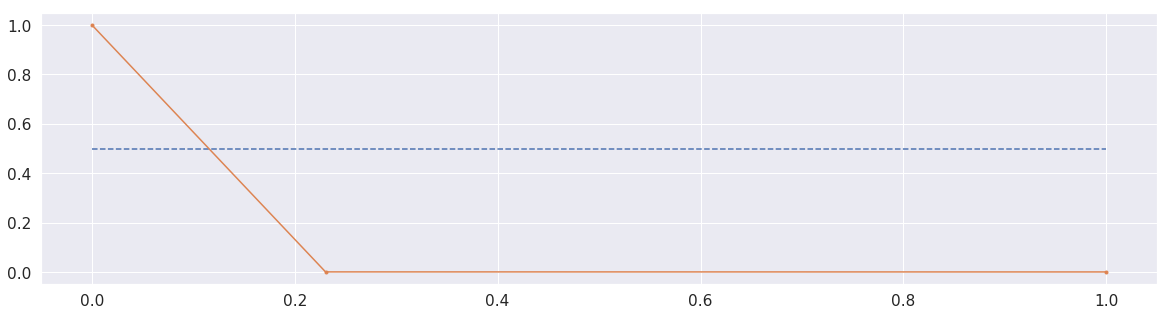

In [208]:
print_precision_recall_curve(y_test, y_random)

# Logistic regression to start off basic
A logistic regression model is a linear model

In [136]:
from sklearn.linear_model import LogisticRegression

In [162]:
clf = LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs', max_iter=1, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


ACCURACY: (What proportion of classes are being classified as theft or not theft correctly?) 83.11%
PRECISION: (If predicted as theft, how likely is it to be theft?) 0.19%
RECALL: (If it was theft, how likely is it I predicted it?) 34.80%

F1: 0.0037
ROC-AUC: 0.5898


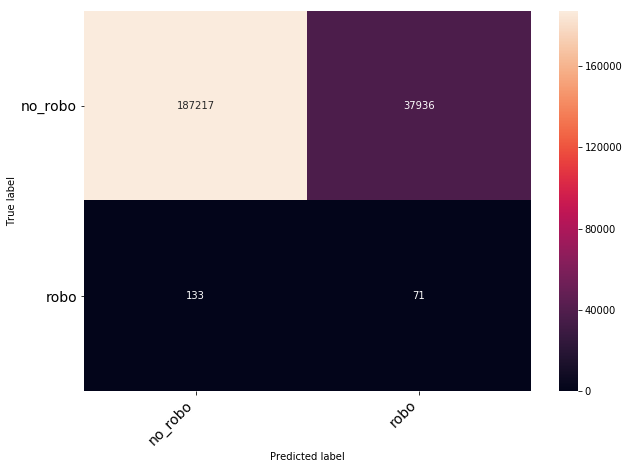

In [165]:
# Now we can do the same evaluation as before, except this time we are actually building a logistic regression (linear) model
# to classify the thefts or non-thefts. We can see a significant improvement, specifically in recall, although accuracy decreases.
y_pred_classes = (y_pred[:, 1] > 0.6).astype(int)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), class_names, figsize = (10,7), fontsize=14);

show_metrics(y_test, y_pred_classes)

We can see that the recall is not bad (about half of the thefts are classified as thefts), but the precision continues to be very low. However, if we think about this, it is not actually a bad thing. We do not expect to be able to predict with certainty whether a trip will be stolen, just what are the risk factors for that trip and what the danger level is. 

When a trip is in a high danger level, it does not mean it is going to be stolen. It continues to be relatively unlikely for a trip to be stolen, even if it leaves in the most dangerous conditions possible. This is what our model is picking up on.

0.6656859392258144


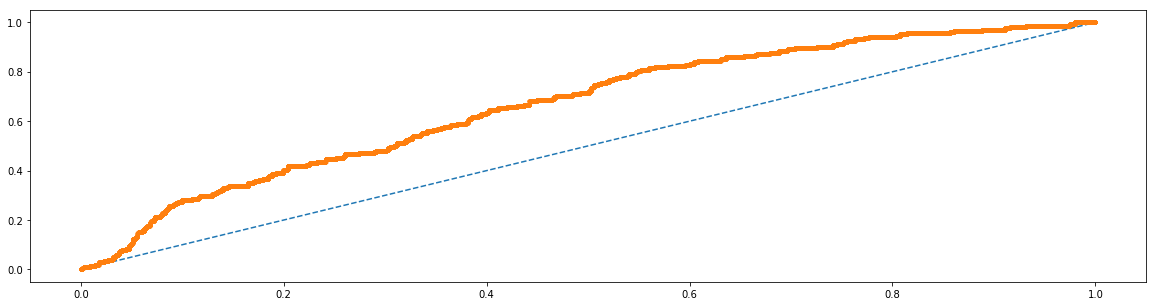

In [166]:
# This curve demonstrates the effectiveness of a model, where the orange line is the balance between precision and recall at every
# potential theshold of deciding whether it is a theft or not a theft. The blue line is equivalent to a naive model (always predicts mean),
# whereas the orange line is our current model (higher is better). We can see a significant improvement compared to the naive model,
# however the ROC curve is particularly friendly to class imbalanced datasets. We can use the precision-recall curve to better
# evaluate these types of problems.
print_roc(y_test, y_pred[:, 1])

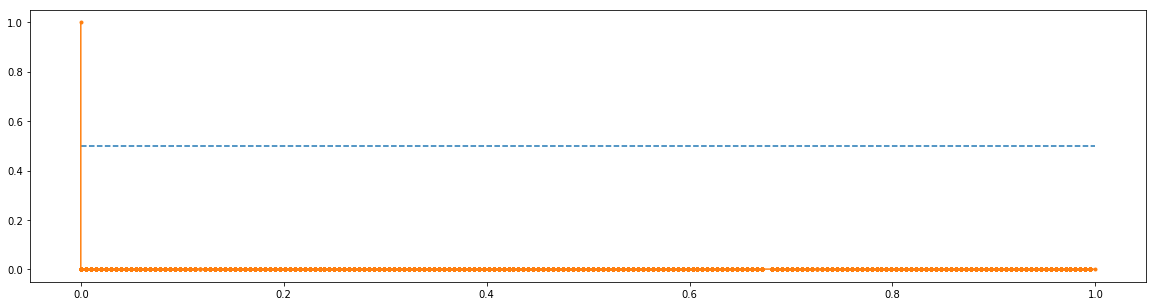

In [167]:
# We can see that this model is is struggling to get anywhere on the precision axis. As expected, it is very difficult to actually
# classify only actual thefts as thefts, without catching non-thefts, given the randomness of the problem.
print_precision_recall_curve(y_test, y_pred[:, 1])

# Looks like the precision is always going to be so low, due to randomness, that this curve really doesn't suit us much.

# Knn
Due to the massive class imbalance, it is difficult to get it to....

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=50, weights='uniform', leaf_size=30, n_jobs=-1)
knn.fit(X_train_under, y_train_under)
y_pred = knn.predict_proba(X_test)

ACCURACY: (What proportion of classes are being classified as theft or not theft correctly?) 87.35%
PRECISION: (If predicted as theft, how likely is it to be theft?) 0.25%
RECALL: (If it was theft, how likely is it I predicted it?) 34.80%

F1: 0.0050
ROC-AUC: 0.6110


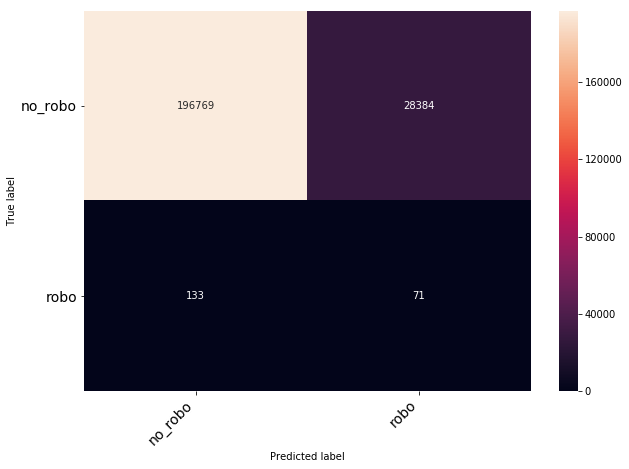

In [41]:
y_pred_classes = (y_pred[:, 1] > 0.5).astype(int)
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.6913504372582199


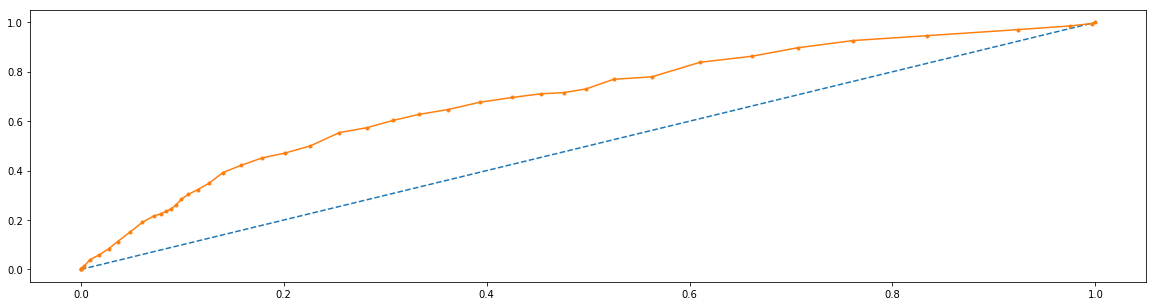

In [42]:
print_roc(y_test, y_pred[:, 1])

# Decision tree - sanity check
Decision trees are basic models that are easy to understand and can be highly effective, especially when used in ensemble methods (random forest).

First let's try training a decision tree on our dataset and see if the decision tree is actually able to distinguish between thefts and non-thefts.


If not at all, this would mean that what we are trying to do is essentially impossible.

In [15]:
from sklearn.tree import DecisionTreeClassifier

ACCURACY: (What proportion of classes are being classified as theft or not theft correctly?) 99.86%
PRECISION: (If predicted as theft, how likely is it to be theft?) 39.51%
RECALL: (If it was theft, how likely is it I predicted it?) 100.00%

F1: 0.5664
ROC-AUC: 0.9993


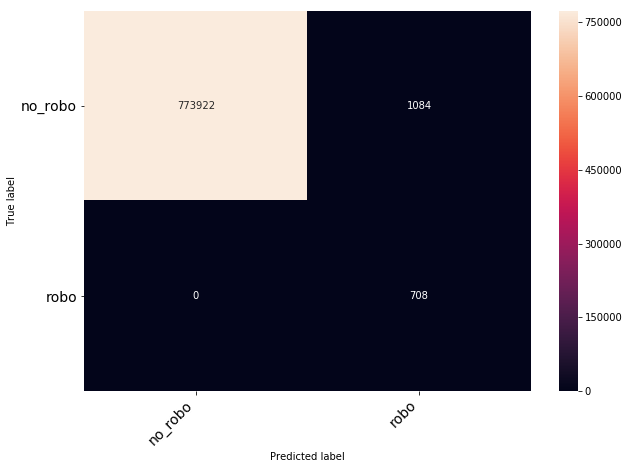

In [203]:
clf = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=1)
clf.fit(X_train, y_train)

# Now we predict again on our training set. In theory, it should be able to 'remember' every row, unless there are many duplicates.
y_pred = clf.predict_proba(X_train)
y_pred_classes = (y_pred[:, 1] > 0.5).astype(int)
show_metrics(y_train, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_train, y_pred_classes), figsize = (10,7), fontsize=14);

So even in the perfect case, it is impossible to get our precision above 40% (which is not necessarily bad). 

But this shows that we are never going to be able to distinguish perfectly between thefts and non-thefts.

0.9999234605889182


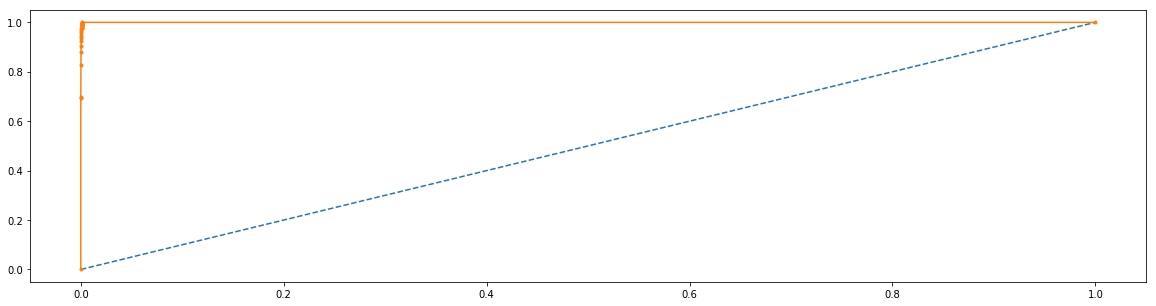

In [204]:
print_roc(y_train, y_pred[:, 1])

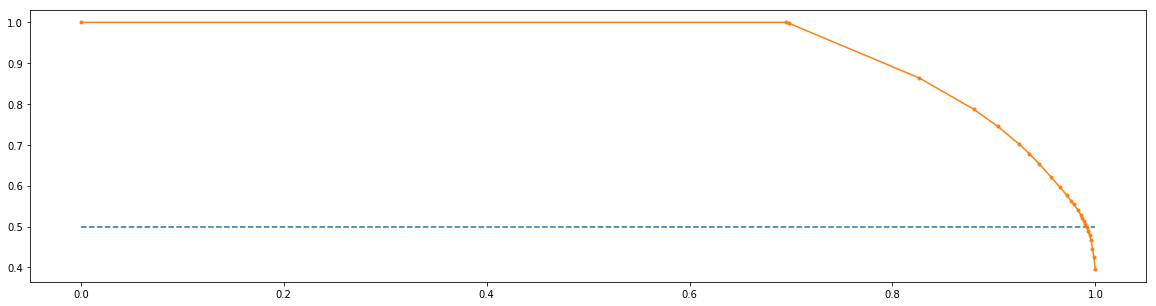

In [205]:
# Again, we see that precision-recall curve is basically always going to be very low at every threshold, given the always very low precision
print_precision_recall_curve(y_train, y_pred[:, 1])

# Decision tree - now for real

In [16]:
clf = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=10)
clf.fit(X_train_under, y_train_under)
y_pred = clf.predict_proba(X_test);

ACCURACY : 70.28% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.16% (If predicted as theft, how likely is it to be theft?)
RECALL   : 53.43% (If it was theft, how likely is it I predicted it?)

F1: 0.0032

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 1.81x more likely to be stolen


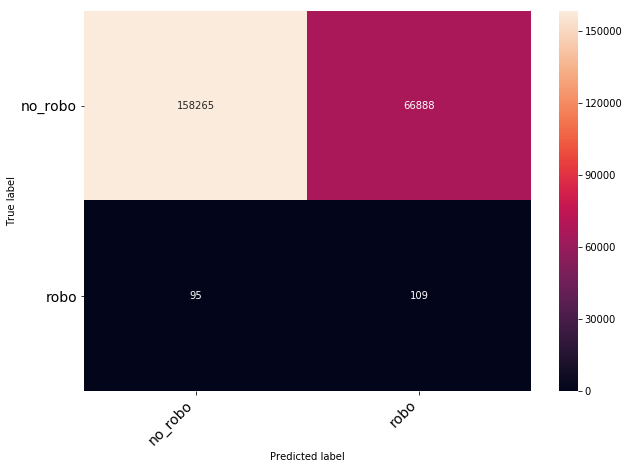

In [17]:
y_pred_classes = (y_pred[:, 1] > 0.5).astype(int)
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.6743034888781075


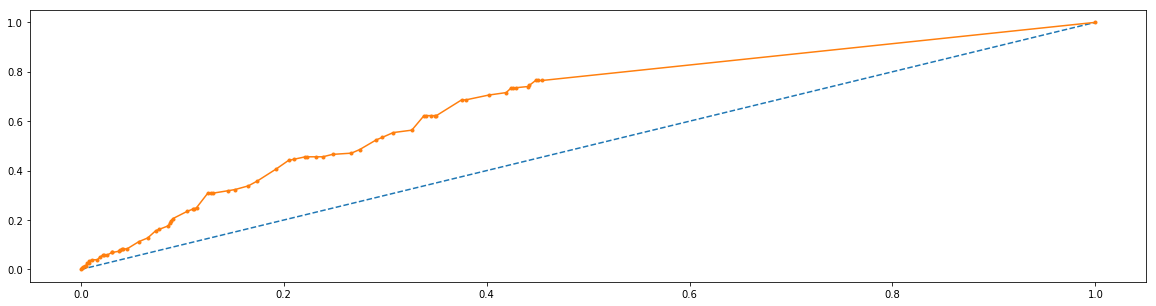

In [18]:
print_roc(y_test, y_pred[:, 1])

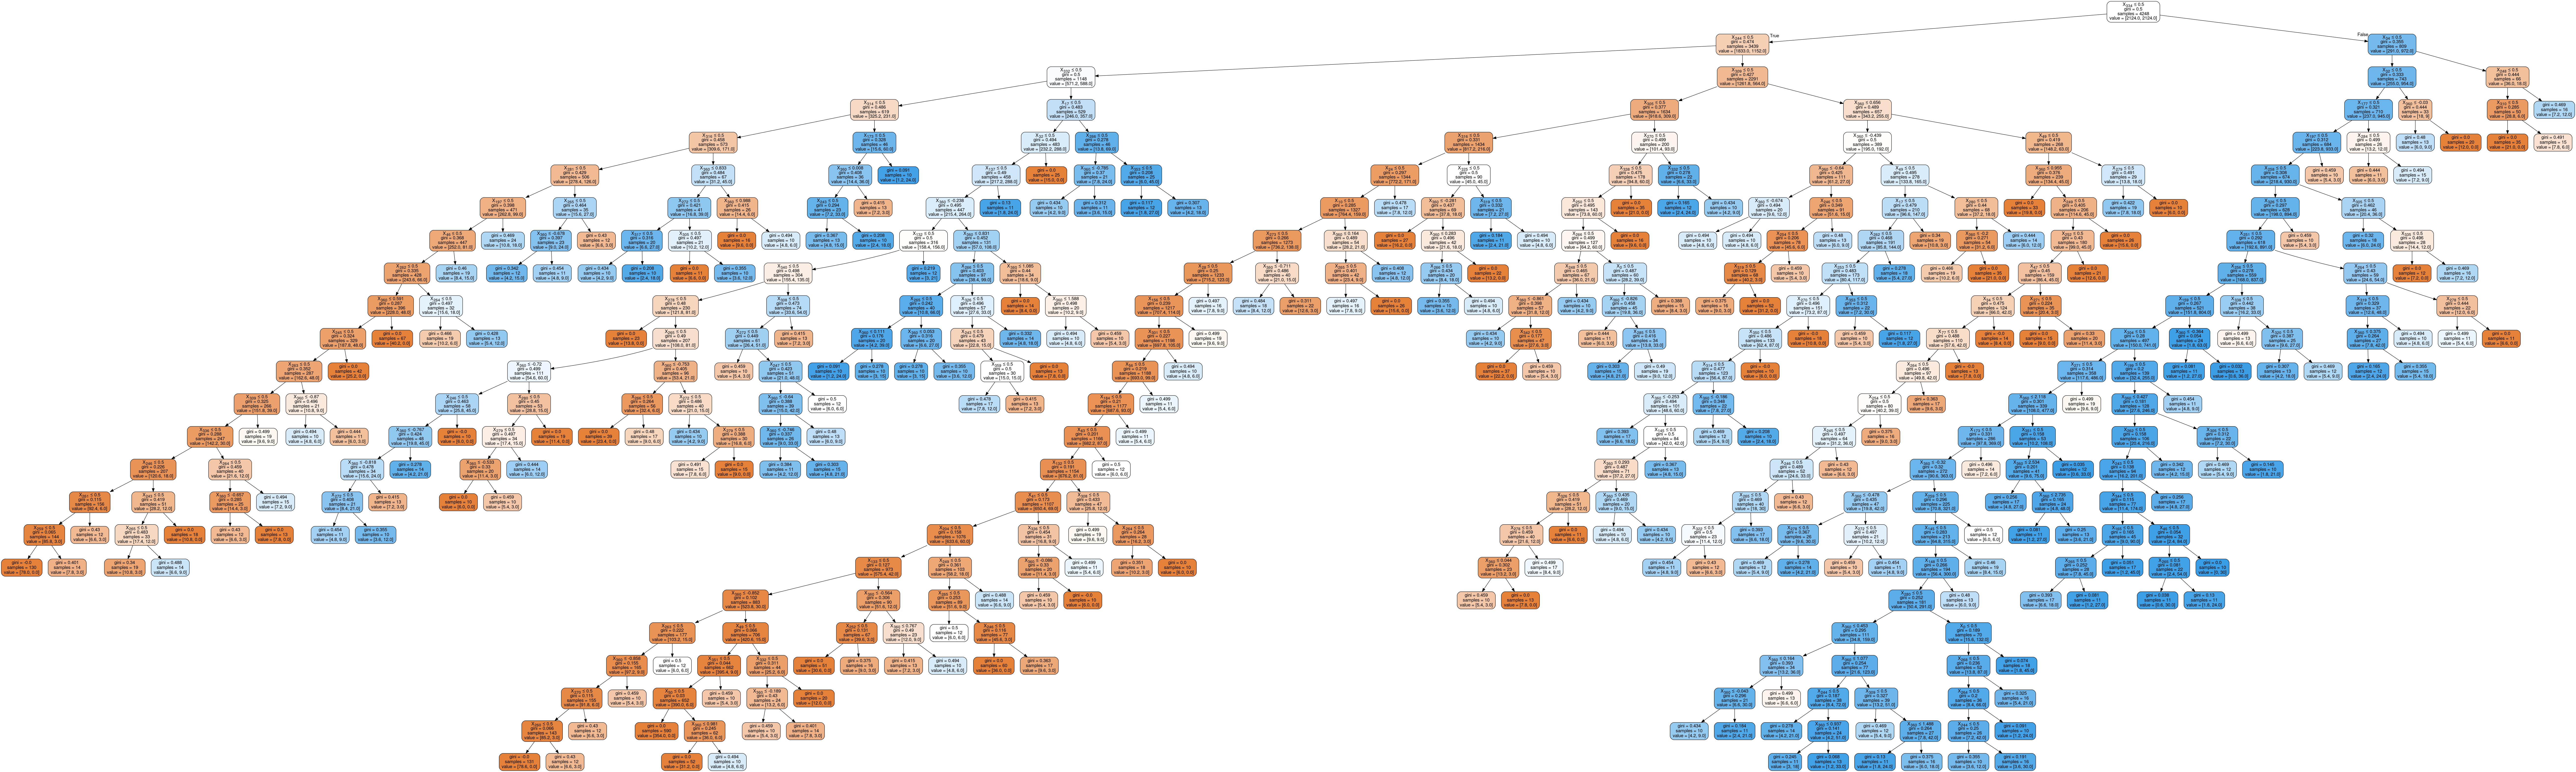

In [19]:
Image(print_decision_tree(clf))

In [21]:
X_train.columns[34]

'customer_id_141'

One great thing about decision trees is that we can always see why our model is making a certain decision. We can just follow the path in the tree, and see how many samples are represented in each one.

For example, the 334-th column always appears at the top of our decision trees. This means that this is the single most important factor in distinguishing between a theft and a non-theft. We can see which column this is just by checking.

In [207]:
print(X_train.columns[334])
print(ghh.decode('101220210', bits_per_char=2))

geohash_101220210
(-98.0859375, 19.16015625)


We can see that it has given us one of our geohashes. We can check where this is easily using a maps application:

<img src="./img/geohash_101220210.png" width=500/>

We can see that this is an area around Puebla, and seeing as this is actually one of our 'parent' geohashes, this is covering an area of around 80km x 40km.

More generally, we can see what the decision tree ranks as the top 10 variables in the tree:

In [187]:
top_10_features = list(sorted(range(len(clf.feature_importances_)), key=lambda i: clf.feature_importances_[i])[-10:])
top_10_features.reverse()
top_10_features
for variable, amount in zip(X_train.columns[top_10_features].values, clf.feature_importances_[top_10_features]):
    print()
    print("the variable {} has an influence of {}".format(variable, amount))


the variable geohash_1012202100 has an influence of 0.07519392296164357

the variable geohash_101220210 has an influence of 0.07120625300520572

the variable geohash_1012201223 has an influence of 0.05287830823546234

the variable geohash_1012201222 has an influence of 0.038437147453065375

the variable time_travel has an influence of 0.03583181066326124

the variable AUTOPISTA MEXICO PUEBLA has an influence of 0.035206683767343094

the variable trailer has an influence of 0.03425628779532254

the variable geohash_1012202103 has an influence of 0.033991431643435224

the variable geohash_1012201230 has an influence of 0.032428640958925184

the variable geohash_101220122 has an influence of 0.032199937857643385


We can see that multiple geohashes exist in this list, but also the time_travel variable (how long the journey will take), the 'peak_start' variable (whether it starts during the peak hours of the morning), the 'trailer' vehicle type, and even (sometimes) a particular customer, who happens to be "PENDIENTE" (whether this is an actual customer name or a placeholder we do not know...)

In [240]:
customer_catalog.loc[141]

account_name    PENDIENTE 
Name: 141, dtype: object

# Random Forests

Why random forests? Firstly, it is a great baseline model. We have large class imbalance and random forest can be good for that. We want model interpretability as well, this can be done by a random forest. ...

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                             max_depth=10, max_features='sqrt',
            n_estimators=100, n_jobs=-1, oob_score=False, verbose=1)

clf.fit(X_train_under, y_train_under);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [31]:
y_pred = clf.predict_proba(X_test)

y_pred_classes = (y_pred[:, 1] > 0.3).astype(int)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


ACCURACY : 50.00% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.14% (If predicted as theft, how likely is it to be theft?)
RECALL   : 79.41% (If it was theft, how likely is it I predicted it?)

F1: 0.0029

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 1.60x more likely to be stolen


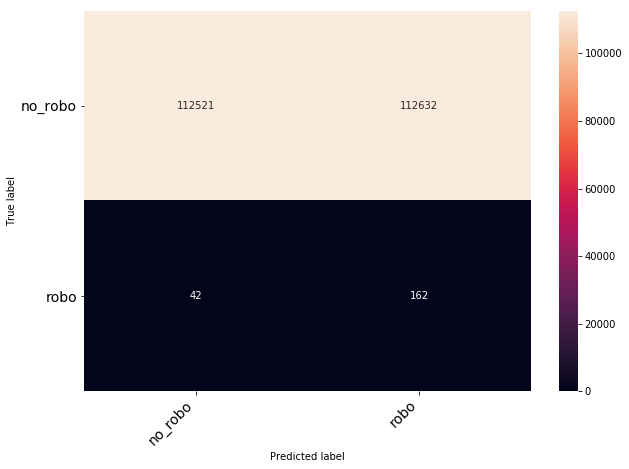

In [32]:
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.7142470026699926


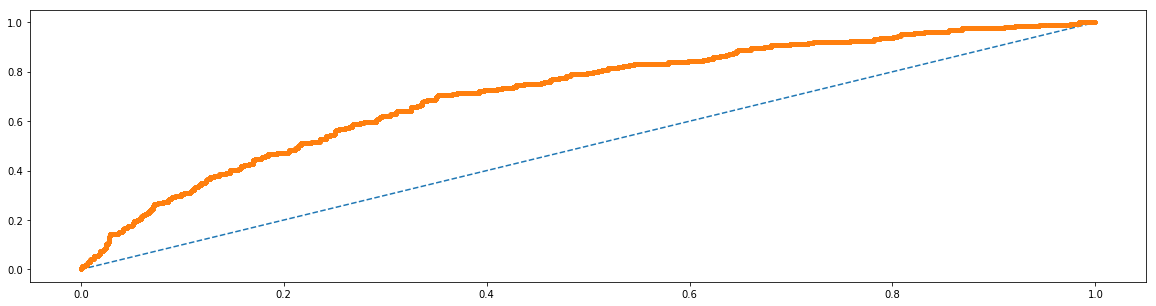

In [33]:
print_roc(y_test, y_pred[:, 1])

# Understanding feature importances of random forest

In [225]:
top_20_features = list(sorted(range(len(clf.feature_importances_)), key=lambda i: clf.feature_importances_[i])[-20:])
top_20_features.reverse()
top_20_features
for variable, amount in zip(X_train.columns[top_20_features].values, clf.feature_importances_[top_20_features]):
    print("the variable {} has an influence of {}".format(variable, amount))
    print()

the variable geohash_1012202100 has an influence of 0.04522176667245014

the variable time_travel has an influence of 0.03539365022376459

the variable geohash_101220210 has an influence of 0.0343969314989489

the variable AUTOPISTA MEXICO PUEBLA has an influence of 0.030169257828204395

the variable geohash_1012202103 has an influence of 0.026121582915129223

the variable trailer has an influence of 0.024474375917907555

the variable geohash_1012201222 has an influence of 0.02217049005505573

the variable geohash_101223211 has an influence of 0.021249913353166776

the variable geohash_1012232112 has an influence of 0.020444241245161386

the variable geohash_1012201223 has an influence of 0.020042576654689767

the variable geohash_1012202101 has an influence of 0.020007925759508792

the variable geohash_1012201230 has an influence of 0.01897708606795105

the variable geohash_101220122 has an influence of 0.01693512388200512

the variable camioneta has an influence of 0.0163122364070837

We can see a similar selection of variables coming through, although this time not particular customers. A lot of geohashes, trailer vehicle type, and the certain road type.

The limitation here is that this gives us the overall importance of each feature. but not for an individual prediction. We'd love to have that too. Let's try another library that can help us with this.

# Playing with tree interpreter
Using this library, we can interpret the output of the model on a per-prediction basis. i.e., why did the model make that decision?

In [34]:
from treeinterpreter import treeinterpreter as ti

In [35]:
# Let's take a look at a single theft - 8 in our test set, and see what our model classifies it as
instances = X_test.iloc[8:9]
print(clf.predict(instances))

[1]


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [36]:
# It predicts it as a 1. Let's see why
prediction, bias, contributions = ti.predict(clf, instances)
cs = contributions[0, :, 1]
cs2 = np.abs(cs)
cs2 = list(sorted(range(len(cs)), key=lambda i: cs[i])[-20:])
# cs2 = cs2.reverse()
for feature, contribution in zip(X_train.columns[cs2], cs[cs2]):
    print(feature, contribution)

geohash_1012201220 0.0028240176867083576
geohash_101220223 0.003264725475939819
geohash_1012201203 0.0035438220730703773
BACARDI TULTITLAN - MONTERREY 0.003636999387403286
geohash_101220121 0.003921781037749749
camioneta 0.004840334290365711
geohash_1012201213 0.005631817930759942
customer_id_141 0.006018893199496618
month_4 0.006136014305994031
Circuito Exterior 0.007890705150331367
time_travel 0.008466822696846135
trailer 0.010511621432462134
geohash_101220123 0.013609201204455185
geohash_1012201221 0.01523396625814988
geohash_101220122 0.017456539010703827
AUTOPISTA MEXICO PUEBLA 0.030423956188234028
geohash_1012202100 0.03813027896817522
geohash_1012202103 0.04174155553317218
geohash_1012201230 0.042918197271042756
geohash_101220210 0.06684858489160893


We can see for this particular example that it is using the AUTOPISTA MEXICO PUEBLA as the most dangerous factor, along with several geohashes, the journey length, the type of vehicle, customer ID, etc...

Note that this doesn't necessarily mean that this is the aspects of this example, perhaps it is the negative. These are just the factors that are making a 'theft' more likely for this particular example. For example, we can see that the vehicle type for this trip is not a trailer - this is implying that a trailer is LESS risky, taking into account all the other variables of this trip)

In [233]:
instances['trailer'].values

array([0])

# Hyper-parameter optimization (Bayesian Optimization)
We can use a technique such as grid searching, or perhaps bayesian optimization, in order to optimize modeling results. This is where we try to optimize hyper-parameters in order to give us the best results possible.

In [116]:
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

def rfc_cv(n_estimators, max_depth, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.
    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_features. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.
    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_features that minimzes the log loss.
    """
    estimator = RFC(
        n_estimators=n_estimators,
        class_weight='balanced',
        max_depth=max_depth,
        bootstrap=True,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=0,
        n_jobs=-1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=make_scorer(roc_auc_score), cv=3)
    return cval.mean()


def optimize_rfc(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, max_depth, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 100),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.2),
            "max_depth": (2, 10)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    
data, targets = X_train, y_train

print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(data, targets)

--- Optimizing Random Forest ---
|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.6709   |  3.532    |  0.1622   |  12.07    |  80.68    |
|  2        |  0.6674   |  8.24     |  0.1273   |  8.359    |  82.17    |
|  3        |  0.6564   |  9.665    |  0.1876   |  10.23    |  55.09    |
|  4        |  0.6709   |  7.468    |  0.1713   |  10.52    |  60.51    |
|  5        |  0.6776   |  6.025    |  0.1014   |  19.78    |  89.44    |
|  6        |  0.6603   |  2.0      |  0.1      |  25.0     |  10.0     |
|  7        |  0.6603   |  2.0      |  0.1      |  2.0      |  10.0     |
|  8        |  0.6498   |  10.0     |  0.2      |  25.0     |  72.99    |
|  9        |  0.6652   |  2.453    |  0.185    |  2.234    |  99.66    |
|  10       |  0.6639   |  2.056    |  0.1467   |  2.295    |  41.1     |
|  11       |  0.6564   |  9.696    |  0.1001   |  24.97    |  99.93    |
|  12

# Trying 'optimized' random forest with new hyper-parameters

In [117]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=6, max_features=0.1, min_samples_split= 20,
            n_estimators=90, n_jobs=-1)

clf.fit(X_train, y_train);

In [118]:
y_pred = clf.predict_proba(X_test)

y_pred_classes = (y_pred[:, 1] > 0.5).astype(int)

ACCURACY : 84.37% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.23% (If predicted as theft, how likely is it to be theft?)
RECALL   : 39.22% (If it was theft, how likely is it I predicted it?)

F1: 0.0045

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 2.53x more likely to be stolen


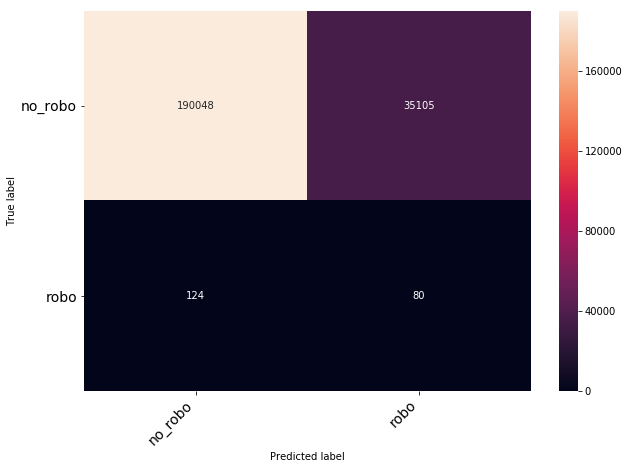

In [119]:
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.6950120649984155


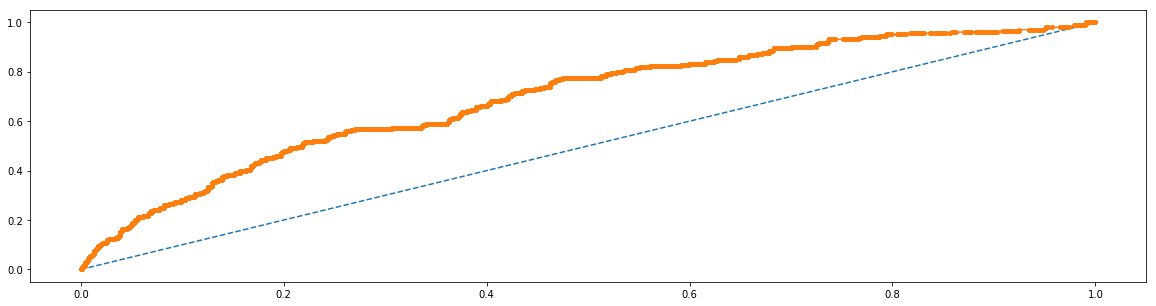

In [120]:
print_roc(y_test, y_pred[:, 1])

# XGBoost
XGBoost is one of the most popular algorithms for machine learning, given it's ease of use and impressive results.

In [37]:
import xgboost as xgb

In [38]:
dtrain = xgb.DMatrix(pd.DataFrame(X_train, columns=X_train.columns), y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [39]:
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'binary:logistic', 'subsample':0.6,
         'scale_pos_weight' : 1000, 'max_delta_step' : 0.3}
param['nthread'] = 16
param['eval_metric'] = 'aucpr'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-aucpr:0.001378	train-aucpr:0.002381
[1]	eval-aucpr:0.001563	train-aucpr:0.002821
[2]	eval-aucpr:0.00163	train-aucpr:0.003029
[3]	eval-aucpr:0.001741	train-aucpr:0.00327
[4]	eval-aucpr:0.001789	train-aucpr:0.003325
[5]	eval-aucpr:0.001861	train-aucpr:0.003403
[6]	eval-aucpr:0.001878	train-aucpr:0.003428
[7]	eval-aucpr:0.001896	train-aucpr:0.003482
[8]	eval-aucpr:0.001934	train-aucpr:0.003501
[9]	eval-aucpr:0.001824	train-aucpr:0.003815
[10]	eval-aucpr:0.001897	train-aucpr:0.00407
[11]	eval-aucpr:0.001977	train-aucpr:0.004433
[12]	eval-aucpr:0.001985	train-aucpr:0.004479
[13]	eval-aucpr:0.0022	train-aucpr:0.00472
[14]	eval-aucpr:0.002359	train-aucpr:0.005221
[15]	eval-aucpr:0.002363	train-aucpr:0.00536
[16]	eval-aucpr:0.002358	train-aucpr:0.005415
[17]	eval-aucpr:0.002313	train-aucpr:0.005408
[18]	eval-aucpr:0.002324	train-aucpr:0.005457
[19]	eval-aucpr:0.002428	train-aucpr:0.00573


In [40]:
y_pred = bst.predict(dtest)
y_pred_classes = (y_pred > 0.5).astype(int)

ACCURACY : 79.78% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.22% (If predicted as theft, how likely is it to be theft?)
RECALL   : 48.04% (If it was theft, how likely is it I predicted it?)

F1: 0.0043

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 2.39x more likely to be stolen


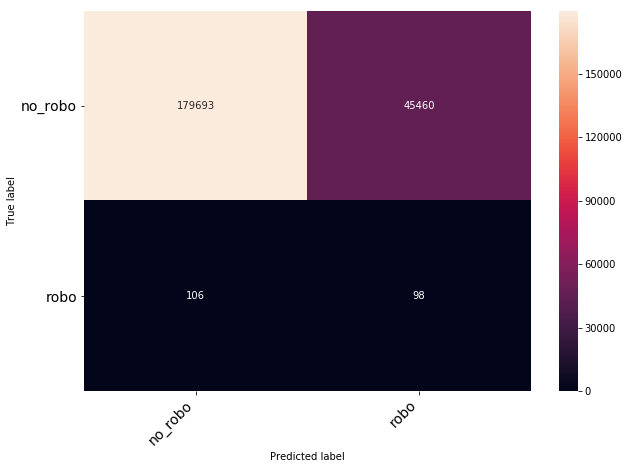

In [41]:
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.7114271772319006


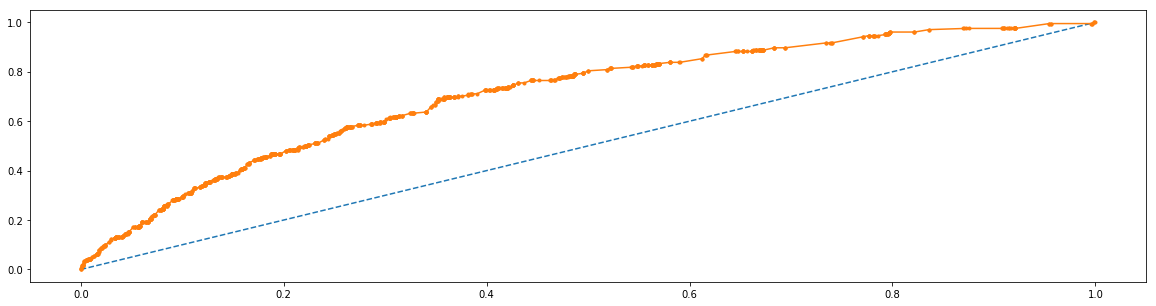

In [42]:
print_roc(y_test, y_pred)

# XGBoost With cluster_column dataset

In [42]:
import xgboost as xgb

In [80]:
dtrain = xgb.DMatrix(pd.DataFrame(X_train, columns=X_train.columns), y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [81]:
param = {'max_depth': 7, 'eta': 0.19090822892075673, 'objective': 'binary:logistic',
         'subsample':0.7989923901720046, 'gamma':0.16348171046596183, 'alpha':1.5063377708791652,
         'colsample_bytree':0.5069130631797323,
         #'scale_pos_weight' : 1000,
         'max_delta_step' : 1.7374830423510295, 'min_child_weight':2.291153900970772}
param['nthread'] = 16
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.5	train-auc:0.5
[1]	eval-auc:0.5	train-auc:0.5
[2]	eval-auc:0.5	train-auc:0.5
[3]	eval-auc:0.499982	train-auc:0.502108
[4]	eval-auc:0.499982	train-auc:0.502108
[5]	eval-auc:0.499982	train-auc:0.502108
[6]	eval-auc:0.499982	train-auc:0.502108
[7]	eval-auc:0.499982	train-auc:0.502108
[8]	eval-auc:0.502415	train-auc:0.504203
[9]	eval-auc:0.588238	train-auc:0.648797
[10]	eval-auc:0.590742	train-auc:0.66358
[11]	eval-auc:0.590986	train-auc:0.664058
[12]	eval-auc:0.590984	train-auc:0.66404
[13]	eval-auc:0.584902	train-auc:0.667224
[14]	eval-auc:0.58443	train-auc:0.671079
[15]	eval-auc:0.584001	train-auc:0.676751
[16]	eval-auc:0.584096	train-auc:0.684221
[17]	eval-auc:0.583293	train-auc:0.692769
[18]	eval-auc:0.583714	train-auc:0.692917
[19]	eval-auc:0.582841	train-auc:0.697066
[20]	eval-auc:0.587406	train-auc:0.699522
[21]	eval-auc:0.601411	train-auc:0.710766
[22]	eval-auc:0.60151	train-auc:0.72209
[23]	eval-auc:0.602467	train-auc:0.727942
[24]	eval-auc:0.605487	train-auc:0.73

In [82]:
y_pred = bst.predict(dtest)
y_pred_classes = (y_pred > 0.0005).astype(int)

ACCURACY : 65.29% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: 0.19% (If predicted as theft, how likely is it to be theft?)
RECALL   : 72.55% (If it was theft, how likely is it I predicted it?)

F1: 0.0038

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is 2.10x more likely to be stolen


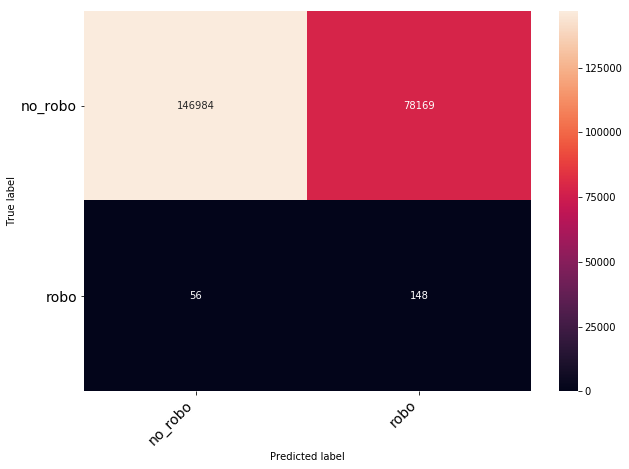

In [83]:
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.7388388967397594


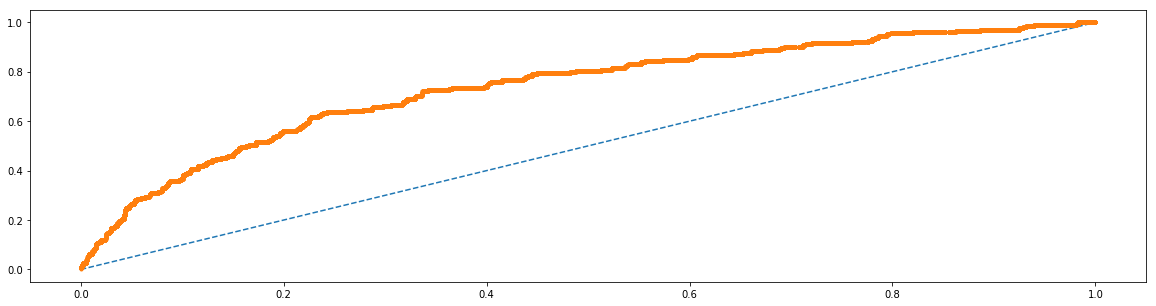

In [84]:
print_roc(y_test, y_pred)

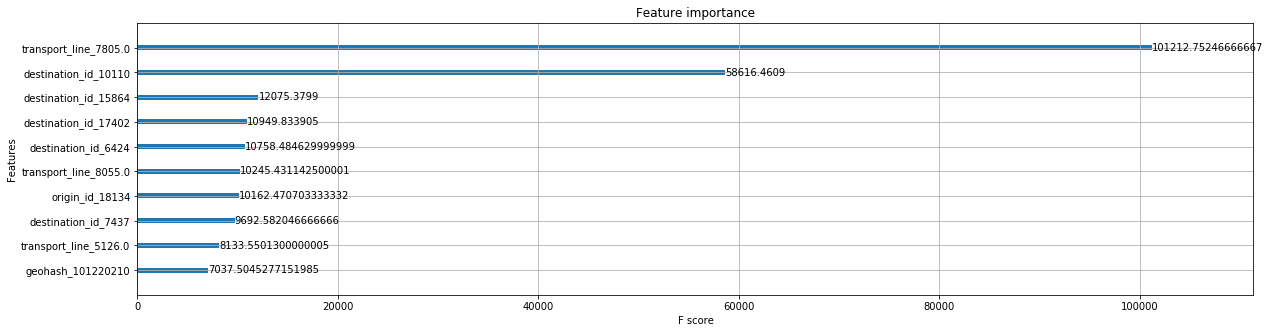

In [92]:
xgb.plot_importance(bst, max_num_features=10, importance_type='cover');

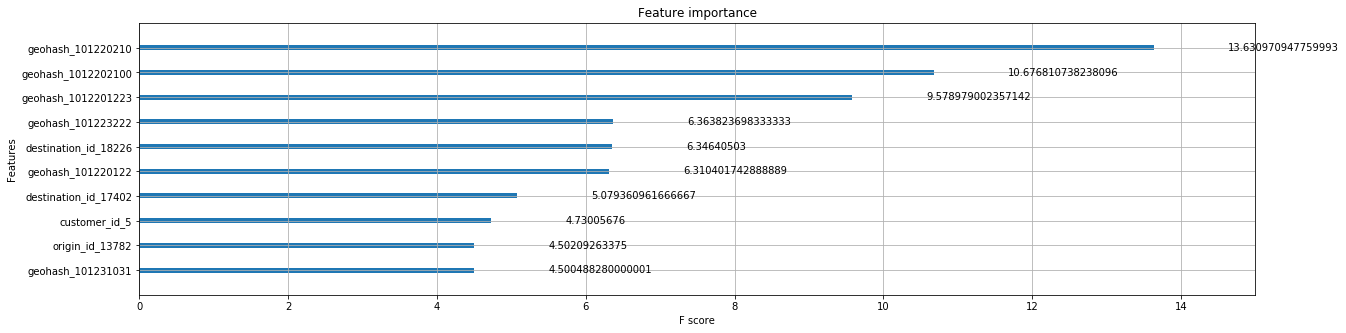

In [93]:
xgb.plot_importance(bst, max_num_features=10, importance_type='gain');

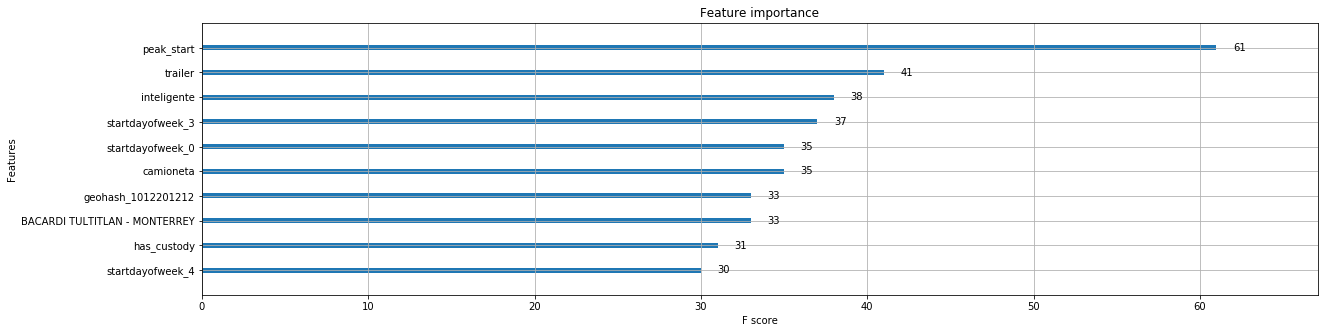

In [94]:
xgb.plot_importance(bst, max_num_features=10, importance_type='weight');

# Training an XGBoost model with SageMaker XGBoost build-in algorithm


In [106]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [123]:
import boto3
import sagemaker
import sagemaker.xgboost
import time
from time import gmtime, strftime
import copy
# get the URI for new container
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

In [135]:
# # save our datasets in format required by sagemaker and upload to S3 bucket for training
pd.concat([pd.DataFrame(y_train), X_train], axis=1).to_csv('train.csv', header=False, index=False)
upload_file('train.csv', bucket='jacobogregoriojuan', object_name='training/train.csv')

pd.concat([pd.DataFrame(y_test), X_test], axis=1).to_csv('test.csv', header=False, index=False)
upload_file('test.csv', bucket='jacobogregoriojuan', object_name='validation/validation.csv')


True

In [136]:
region = boto3.Session().region_name

bucket='jacobogregoriojuan'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
role = get_execution_role()


In [137]:
role

'arn:aws:iam::625803982382:role/service-role/AmazonSageMaker-ExecutionRole-20190806T120142'

In [138]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='0.90-1'); 

In [139]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3'

In [167]:
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 10
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.3",
        "gamma":"0.5",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "binary:logistic",
        "num_round": "100",
        "scale_pos_weight": "1000",
        "eval_metric": "auc"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/training',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}

In [168]:
#single machine job params
single_machine_job_name = 'xgboost-classification' + time.strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", single_machine_job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = single_machine_job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-classification2019-09-12-19-03-57


In [169]:
%%time

sm = boto3.Session(region_name=region).client('sagemaker')

sm.create_training_job(**single_machine_job_params)

status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=single_machine_job_name)
status = sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=single_machine_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 6min


In [170]:
s3 = boto3.client('s3')
s3.download_file(bucket, 
                 "xgboost-single/"+single_machine_job_name,
                 'model.tar.gz')

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
import tarfile
tf = tarfile.open("model.tar.gz")
tf.extractall()

In [ ]:
import pickle as pkl 
import xgboost as xgb

model_file_path = 'xgboost-model'
model = pkl.load(open(model_file_path, 'rb'))
# prediction with test data
dtest = xgb.DMatrix(X_test.to_numpy(), y_test)
y_pred = model.predict(dtest)

In [ ]:
y_pred_classes = (y_pred > 0.5).astype(int)
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

# Hyper-parameter optimization with SageMaker

In [ ]:
# {'max_depth': (2, 7), 'gamma': (0, 1), 'colsample_bytree': (0.3, 0.9),
#  'subsample': (0.5, 0.9),'eta': (0.01, 0.3), 'max_delta_step': (0, 2),
#  'scale_pos_weight': (0, 1000)}

In [ ]:
# prefix = 'sagemaker/DEMO-xgboost-multiclass-classification'

# sm_xgb = sagemaker.estimator.Estimator(
#     container,
#     role, 
#     train_instance_count=1, 
#     train_instance_type='ml.m4.xlarge',
#     output_path='s3://{}/{}/output'.format(bucket, prefix),
#     sagemaker_session=sess
# )

# sm_xgb.set_hyperparameters(
#     eval_metric='auc',
#     objective='binary:logistic',
#     num_round=100,
#     rate_drop=0.3,
#     tweedie_variance_power=1.4
# )
# objective_metric_name = 'validation:auc'

In [ ]:
# hyperparameter_ranges = {
#     'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
#     'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
#     'max_depth': (2, 7), 'gamma': (0, 1), 'colsample_bytree': (0.3, 0.9),
#     'subsample': (0.5, 0.9),'eta': (0.01, 0.3), 'max_delta_step': (0, 2),
#     'scale_pos_weight': (0, 1000)
# }

In [183]:
from time import gmtime, strftime, sleep
tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())

print (tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.3",
          "MinValue": "0.01",
          "Name": "eta",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha",            
        },
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "gamma",
        },
        {
          "MaxValue": "0.9",
          "MinValue": "0.3",
          "Name": "colsample_bytree",
        },
        {
          "MaxValue": "0.9",
          "MinValue": "0.5",
          "Name": "subsample",
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "max_delta_step",
        }
    ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "7",
          "MinValue": "2",
          "Name": "max_depth",
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 50,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

xgboost-tuningjob-12-19-23-34


In [184]:
s3_input_train = 's3://{}/training'.format(bucket)
s3_input_validation ='s3://{}/validation/'.format(bucket)
training_image = container
prefix = 'sagemaker/DEMO-xgboost-multiclass-classification'
    
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "200",
      "objective": "binary:logistic",
      "rate_drop": "0.2"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [185]:
smclient = boto3.Session().client('sagemaker')
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:625803982382:hyper-parameter-tuning-job/xgboost-tuningjob-12-19-23-34',
 'ResponseMetadata': {'RequestId': 'c31108a5-b59f-41ac-ac57-fcfbe900d153',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c31108a5-b59f-41ac-ac57-fcfbe900d153',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Thu, 12 Sep 2019 19:23:38 GMT'},
  'RetryAttempts': 0}}

In [186]:
smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [ ]:
# Now let's train a model with our finally chosen hyper parameters and run our metrics on this.


# Deep learning with mxnet

In [164]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from multiprocessing import cpu_count

ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

In [168]:
num_outputs = 1
num_hidden = 64
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
binary_cross_entropy = gluon.loss.SigmoidBCELoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [172]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [ ]:
CPU_COUNT = cpu_count()

train_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(X_train_under.astype(int)), nd.array(y_train_under.astype(int)))
test_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(X_test.astype(int)), nd.array(y_test.astype(int)))

train_data = mx.gluon.data.DataLoader(train_dataset, batch_size=512, num_workers=CPU_COUNT)
print('loaded train data')
test_data = mx.gluon.data.DataLoader(test_dataset, batch_size=512, num_workers=CPU_COUNT)
print('loaded test data')

for X_batch, y_batch in train_data:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))
    break

In [ ]:
epochs = 100
smoothing_constant = .01
num_examples = len(X_train_smote)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
#         print(i)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = binary_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

In [183]:
data = nd.array(X_test).as_in_context(ctx)
label = nd.array(y_test).as_in_context(ctx)
output = net(data)
predictions = nd.argmax(output, axis=1)

In [184]:
y_pred = predictions.asnumpy()
y_pred_classes = (y_pred > 0.5).astype(int)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


ACCURACY : 99.91% (What proportion of classes are being classified as theft or not theft correctly?)
PRECISION: nan% (If predicted as theft, how likely is it to be theft?)
RECALL   : 0.00% (If it was theft, how likely is it I predicted it?)

F1: 0.0000

baseline proportion of thefts is ~ 0.09%
with this model, a journey predicted as theft is nanx more likely to be stolen


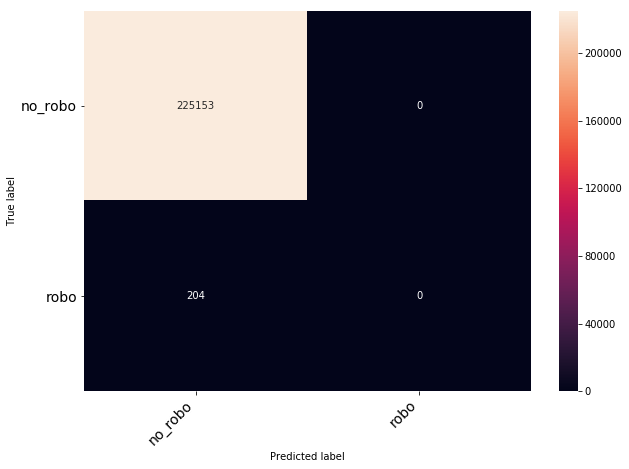

In [185]:
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

0.5


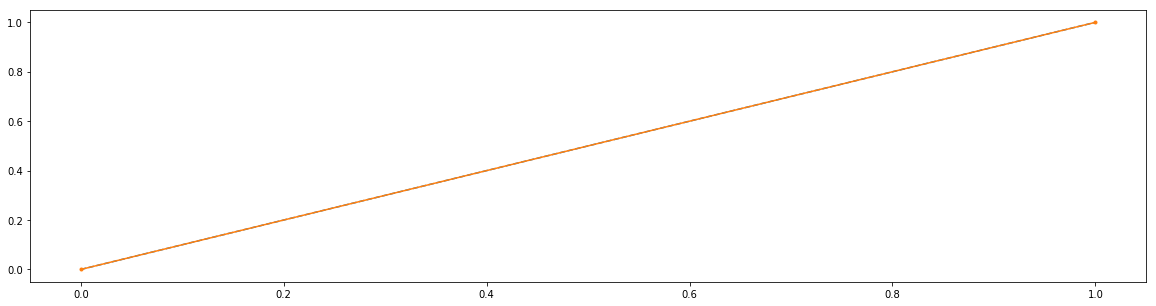

In [186]:
print_roc(y_test, y_pred)

Very limited experimentation, but it has been very difficult to get the model to learn anything at all given the large class imbalance.

# Evaluating and ranking our models

https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
Use precision and recall to focus on small positive class — When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall.

### Models tried:
1. (Unsupervised learning & Visualization) K-Means Clustering & PCA
2. K-Nearest Neighbours
2. Logistic Regression
3. Decision Tree
4. Random Forest
5. XGBoost
6. Neural Network (Deep Learning)

### Overall results
...

In [111]:
import boto3
import sagemaker
import sagemaker.xgboost
import time
from time import gmtime, strftime
import copy
# get the URI for new container
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

In [6]:
# Create our final test set
df_all_final = pd.read_csv("s3://ilsp-stole-data/to_predict/info_to_predict.csv", encoding = "Windows-1252",
                          error_bad_lines=False)
pre_planned_data_final = pd.read_csv("s3://ilsp-stole-data/to_predict/into_to_predict_geo.csv")

b'Skipping line 2900: expected 36 fields, saw 39\nSkipping line 3022: expected 36 fields, saw 38\nSkipping line 4467: expected 36 fields, saw 38\nSkipping line 4487: expected 36 fields, saw 39\nSkipping line 4921: expected 36 fields, saw 40\nSkipping line 4922: expected 36 fields, saw 40\nSkipping line 4923: expected 36 fields, saw 40\nSkipping line 4924: expected 36 fields, saw 40\nSkipping line 4946: expected 36 fields, saw 38\nSkipping line 7207: expected 36 fields, saw 39\nSkipping line 8410: expected 36 fields, saw 38\nSkipping line 11581: expected 36 fields, saw 39\nSkipping line 12036: expected 36 fields, saw 39\nSkipping line 12037: expected 36 fields, saw 39\nSkipping line 13978: expected 36 fields, saw 39\nSkipping line 15494: expected 36 fields, saw 38\n'
b'Skipping line 19286: expected 36 fields, saw 38\nSkipping line 22793: expected 36 fields, saw 39\nSkipping line 24689: expected 36 fields, saw 39\nSkipping line 24993: expected 36 fields, saw 40\nSkipping line 25392: expe

In [7]:
df_all_data.head()

NameError: name 'df_all_data' is not defined

In [97]:
# Now let's use our final month's holdout dataset to test performance of our model.
# First let's build a new full training set with all of our data.
X_train_final = pd.concat([X_train, X_test], axis=0)
y_train_final = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], axis=0)

In [109]:
# # save our datasets in format required by sagemaker and upload to S3 bucket for training
pd.concat([pd.DataFrame(y_train_final), X_train_final], axis=1).to_csv('train_final.csv', header=False, index=False)
upload_file('train_final.csv', bucket='jacobogregoriojuan', object_name='training_final/train.csv')

True

In [112]:
# Now we will train our final XGBoost model with this new dataset.
region = boto3.Session().region_name

bucket='jacobogregoriojuan'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
role = get_execution_role()

In [113]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='0.90-1'); 

In [114]:
best_hyperparams = {
        "max_depth":"7",
        "eta":"0.19090822892075673",
        "alpha":"1.5063377708791652",
        "colsample_bytree":"0.5069130631797323",
        "max_delta_step":"1.7374830423510295",
        "rate_drop":"0.2",
        "subsample":"0.7989923901720046",
        "gamma":"0.16348171046596183",
        "min_child_weight":"2.291153900970772",
        "silent":"0",
        "objective": "binary:logistic",
        "num_round": "500",
        "eval_metric": "auc"
    }

In [115]:
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 10
    },
    "HyperParameters": best_hyperparams,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/training_final',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }#,
#         {
#             "ChannelName": "validation",
#             "DataSource": {
#                 "S3DataSource": {
#                     "S3DataType": "S3Prefix",
#                     "S3Uri": bucket_path + '/validation_final',
#                     "S3DataDistributionType": "FullyReplicated"
#                 }
#             },
#             "ContentType": "text/csv",
#             "CompressionType": "None"
#         }
    ]
}

In [118]:
#single machine job params
job_name = 'xgboost-classification-FINAL' + time.strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-classification-FINAL2019-09-12-22-14-22


In [119]:
%%time

sm = boto3.Session(region_name=region).client('sagemaker')

sm.create_training_job(**single_machine_job_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 170 ms, sys: 12.4 ms, total: 182 ms
Wall time: 12min 1s


In [120]:
s3 = boto3.client('s3')
s3.download_file(bucket, 
                 "xgboost-single/"+job_name,
                 'model.tar.gz')

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
import tarfile
tf = tarfile.open("model.tar.gz")
tf.extractall()

In [ ]:
import pickle as pkl 
import xgboost as xgb

model_file_path = 'xgboost-model'
model = pkl.load(open(model_file_path, 'rb'))
# prediction with test data
dtest = xgb.DMatrix(X_test.to_numpy(), y_test)
y_pred = model.predict(dtest)

In [ ]:
y_pred_classes = (y_pred > 0.5).astype(int)
show_metrics(y_test, y_pred_classes)
print_confusion_matrix(confusion_matrix(y_test, y_pred_classes), figsize = (10,7), fontsize=14);

# What might we do to improve our model results?
* MORE DATA - always good to have more if possible
* New features extracted from existing data:
    * Number of estadías?
    * Play with number of routes passed through, geohashes or otherwise
    
* New features created from new data sources:
    * Weather
    * Traffic conditions
    * Third-party security data (governments) about security events

# How can we use this results in a in production solution

* Working backwards. Who are the users? Who will consume this information? How will they consume it?
* Customers - perhaps web app, chat bot, automated system to see why their journey is being marked as dangerous
* 
* Include mockups or demos that Oscar prepared
* 
* How to deploy in AWS (serverless) Lambda. Maybe Sagemaker but perhaps not even necessary.
* Using will require new training and processes

# Implementing our solution in production
* Who/what will use the output of this model?
    * Customers directly (telegram idea)
    * Internal Monitoristas via the dashboard
* AWS Serverless Architecture
    * SageMaker hosted endpoint (sklearn, Xgboost)
    * Lambda
    * API Gateway
    * Automatic retraining (1 per month)
    * Data extraction scripts
* Security


# Conclusions

"When it comes to artificial intelligence, one of the biggest mistakes large companies make is thinking tactically rather than strategically. 

 

What's the difference? Some taxi companies thought they had the internet revolution "covered" because they built a website. Then ride-sharing startups disrupted the industry with internet-connected mobile apps that transformed the ride-hailing experience.

 

Similarly, some companies’ response to AI starts and ends with tactically building a few small projects. But the strategic question is: How will AI transform your industry's core business, and how will that change what it takes for your company to thrive? "